# Reuters News Classification

We are going to implement text classifcation on Reuters News (available through sklearn) based on LSTM method 

In [1]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1. Load Data

In [2]:
# num_words: 1000 to use the words up to 1000th frequently appearing. Put 0 to use all words
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

2113536/2110848 [==============================] - 0s 0us/step


In [3]:
print('Number of Training News : {}'.format(len(X_train)))
print('Number of Test News : {}'.format(len(X_test)))

num_classes = max(y_train) + 1
print('Number of Predictor Classes : {}'.format(num_classes))

Number of Training News : 8982
Number of Test News : 2246
Number of Predictor Classes : 46


In [4]:
# Examine the very first news (Already converted in integers)
print(X_train[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


# 2. EDA

Max length of news :2376
Avg length of news :145.5398574927633


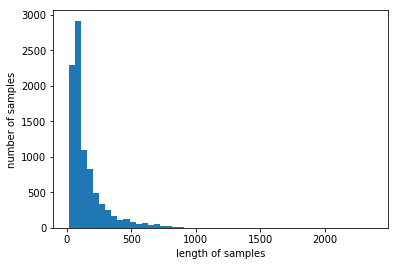

In [5]:
# We also want to check the maximum and average length of news
print('Max length of news :{}'.format(max(len(a) for a in X_train)))
print('Avg length of news :{}'.format(sum(map(len, X_train))/len(X_train)))

plt.hist([len(l) for l in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

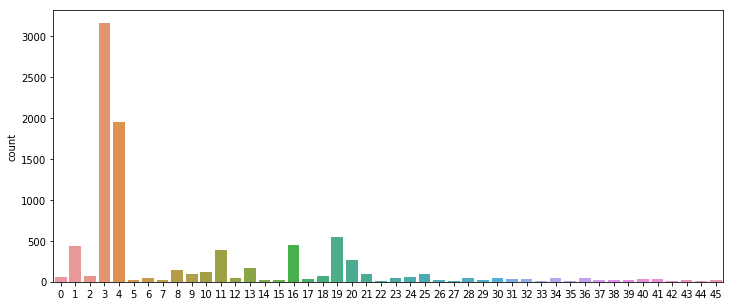

In [6]:
# Check how many each classes have
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train)

We can see the class 3 and 4 has the most number of news

# 3. PreProcessing

The length of the news are all different. We want to make the length equal for all news. 
we gave 100 to max_len in pad_sequences(), which means that we want to make the length of all articles to 100 

In [8]:
max_len = 100
X_train = pad_sequences(X_train, maxlen=max_len) # Training set padding
X_test = pad_sequences(X_test, maxlen=max_len) # Test set padding

In [9]:
y_train = to_categorical(y_train) # Lables in Training set One-hot encoding
y_test = to_categorical(y_test) # Lables in Testing set One-hot encoding

# 4. Modeling

We first create 'Embedding()' layer which receives 2 inputs: first the size of the word-cluster, and second the dimension of vector. So, below codes generated 1,000 vector that has 120 dimension. LSTM layer gets the hidden layer's size 

The last output layers has to get the num_classes of predictor. 

In [10]:
model = Sequential()
model.add(Embedding(1000, 120))
model.add(LSTM(120))
model.add(Dense(num_classes, activation='softmax'))

In [11]:
# Create earlystopping and checkpoint on saving best model (only when val_acc improves)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4) 
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [12]:
# Use 'categorical_crossentropy' on multiclass classification problem
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [13]:
history = model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_test, y_test))

Epoch 1/30
71/71 [==============================] - ETA: 0s - loss: 2.6242 - acc: 0.3377
Epoch 00001: val_acc improved from -inf to 0.36198, saving model to best_model.h5
71/71 [==============================] - 10s 136ms/step - loss: 2.6242 - acc: 0.3377 - val_loss: 2.3547 - val_acc: 0.3620
Epoch 2/30
71/71 [==============================] - ETA: 0s - loss: 2.1471 - acc: 0.4565
Epoch 00002: val_acc improved from 0.36198 to 0.50490, saving model to best_model.h5
71/71 [==============================] - 11s 160ms/step - loss: 2.1471 - acc: 0.4565 - val_loss: 2.0005 - val_acc: 0.5049
Epoch 3/30
71/71 [==============================] - ETA: 0s - loss: 1.8976 - acc: 0.5106- ETA: 3s - loss: 1.9025 
Epoch 00003: val_acc improved from 0.50490 to 0.51959, saving model to best_model.h5
71/71 [==============================] - 18s 256ms/step - loss: 1.8976 - acc: 0.5106 - val_loss: 1.8414 - val_acc: 0.5196
Epoch 4/30
71/71 [==============================] - ETA: 0s - loss: 1.7766 - acc: 0.5340
E

In [14]:
loaded_model = load_model('best_model.h5')

# Check the Testset Accuracy
print("\n Test Accuracy: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

71/71 [==============================] - 1s 16ms/step - loss: 1.2118 - acc: 0.7311

 Test Accuracy: 0.7311


We get the 73% accuracy on test set with the very basic model that has one Embedding and one LSTM layer

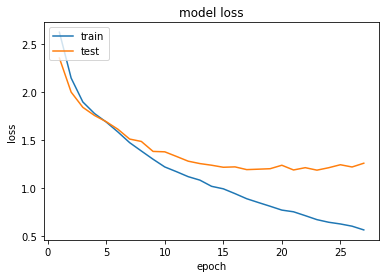

In [15]:
# Check the loss graph
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

Overfitting seems to begin at aronud 5th epoch, which we can improve by adding normalization layers and revising hyperparameters